<a id='top'></a>
<h1 style="text-align:center;font-size:200%;;">Real or Not? NLP with Disaster Tweets</h1>
<img src="https://dataxboost.files.wordpress.com/2018/03/nlp.jpg">

## Competition Description
* Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Notebook Content!</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#libraries" role="tab" aria-controls="profile">Import Libraries<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#load" role="tab" aria-controls="messages">Load Data<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#visual" role="tab" aria-controls="settings">Visualization of data<span class="badge badge-primary badge-pill">3</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#word" role="tab" aria-controls="settings">WordCloud<span class="badge badge-primary badge-pill">4</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#clean" role="tab" aria-controls="settings">Cleaning the text<span class="badge badge-primary badge-pill">5</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#split" role="tab" aria-controls="settings">Train and test Split<span class="badge badge-primary badge-pill">6</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#model" role="tab" aria-controls="settings"> Creating the Model<span class="badge badge-primary badge-pill">7</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#eval" role="tab" aria-controls="settings">Model Evaluation<span class="badge badge-primary badge-pill">8</span></a>  

<a id='libraries'></a>
## 1. Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re
# Natural Language Tool Kit 
import nltk  
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from collections import Counter
import cufflinks as cf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
cf.go_offline()

Using TensorFlow backend.


<a id='load'></a>
# 2. Load Data

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission =  pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<ul style="list-style-type:square;">
  <li><span class="label label-default">id</span> a unique identifier for each tweet</li>
  <li><span class="label label-default">text </span> the text of the tweet</li>
  <li><span class="label label-default">location</span>  the location the tweet was sent from (may be blank)</li>
    <li><span class="label label-default">keyword</span>  a particular keyword from the tweet (may be blank)</li>
    <li><span class="label label-default">target</span>  in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)</li>
</ul>


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
display(HTML(f"""
   
        <ul class="list-group">
          <li class="list-group-item disabled" aria-disabled="true"><h4>Shape of Train and Test Dataset</h4></li>
          <li class="list-group-item"><h4>Number of rows in Train dataset is: <span class="label label-primary">{ train.shape[0]:,}</span></h4></li>
          <li class="list-group-item"> <h4>Number of columns Train dataset is <span class="label label-primary">{train.shape[1]}</span></h4></li>
          <li class="list-group-item"><h4>Number of rows in Test dataset is: <span class="label label-success">{ test.shape[0]:,}</span></h4></li>
          <li class="list-group-item"><h4>Number of columns Test dataset is <span class="label label-success">{test.shape[1]}</span></h4></li>
        </ul>
  
    """))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<a id='visual'></a>
# 3. Visualization of data

In [7]:
missing = train.isnull().sum()  
missing[missing>0].sort_values(ascending=False).iplot(kind='bar',title='Null values present in train Dataset', color=['red'])


In [8]:
train.target.value_counts().iplot(kind='bar',text=['Fake', 'Real'], title='Comparing Tweet is a real disaster (1) or not (0)',color=['blue'])

In [9]:
counts_train = train.target.value_counts(sort=False)
labels = counts_train.index
values_train = counts_train.values

data = go.Pie(labels=labels, values=values_train ,pull=[0.03, 0])
layout = go.Layout(title='Comparing Tweet is a real disaster (1) or not (0) in %')

fig = go.Figure(data=[data], layout=layout)
fig.update_traces(hole=.3, hoverinfo="label+percent+value")
fig.update_layout(
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Train', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [10]:
train['length'] = train['text'].apply(len)

In [11]:
data = [
    go.Box(
        y=train[train['target']==0]['length'],
        name='Fake'
    ),
    go.Box(
        y=train[train['target']==1]['length'],
        name='Real'
    )
]
layout = go.Layout(
    title = 'Comparison of text length in Tweets '
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [12]:
train.keyword.nunique()  # Total of 221 unique keywords

221

In [13]:

train.keyword.value_counts()[:20].iplot(kind='bar', title='Top 20 keywords in text', color='red')

In [14]:
train.location.value_counts()[:20].iplot(kind='bar', title='Top 20 location in tweet', color='blue')  # Check the top 15 locations 

 <a id='word'></a>
#  4. WordCloud

In [15]:
STOPWORDS.add('https')  # remove htps to the world Cloud

def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

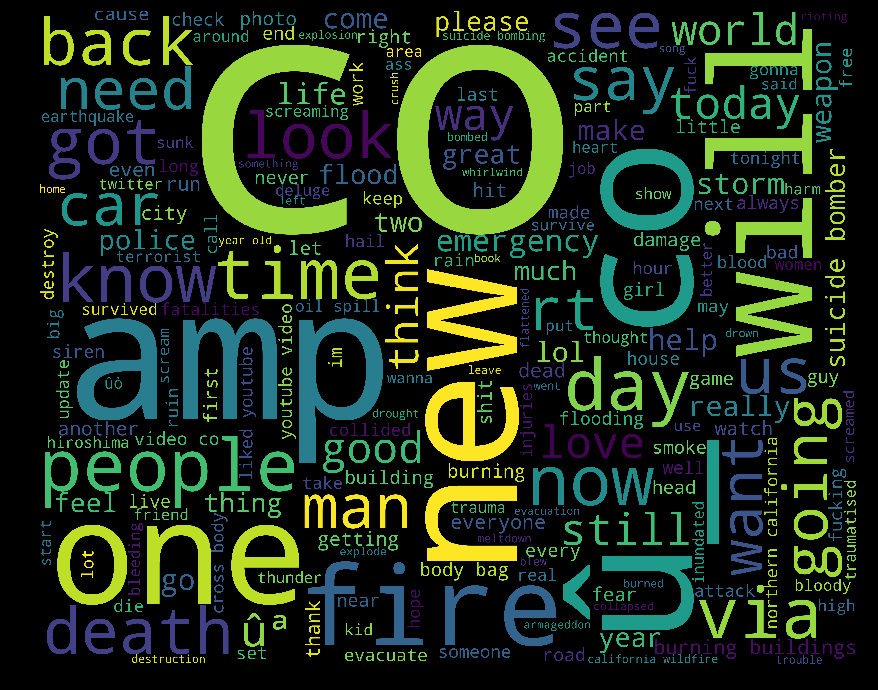

In [16]:
text = train.text.values

Plot_world(text)


<a id='clean'></a>
# 5. Cleaning the text

In [17]:
#How many http words has this text?
train.loc[train['text'].str.contains('http')].target.value_counts()

1    2172
0    1799
Name: target, dtype: int64

In [18]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

In [19]:
# Remove all text that start with html
train['text']=train['text'].apply(lambda x : remove_html(x))

In [20]:
# lets check if this clean works
train.loc[train['text'].str.contains('http')].text

121    Aftershock: Protect Yourself and Profit in the...
Name: text, dtype: object

In [21]:
# Remove all text that start with html in test
test['text']=test['text'].apply(lambda x : remove_html(x))

In [22]:
!pip install pyspellchecker

ERROR: Could not find a version that satisfies the requirement pyspellchecker (from versions: none)
ERROR: No matching distribution found for pyspellchecker


In [23]:

from nltk.tokenize import TweetTokenizer
import string

# Stop words are messy and not that compelling; 
# "very" and "not" are considered stop words, but they are obviously expressing sentiment

stopwords_english = stopwords.words('english')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
punc = string.punctuation

def process_tweet(tweet):
    '''
    Input: 
        tweet: a string containing a tweet
    Output:
        tweets_clean: the processed tweet
    
    '''
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)  

    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    ### START CODE HERE ###
    text = []
    tweets_clean = ""
    for word in tweet_tokens:
        if (word not in stopwords_english): 
            stem_word = lemmatizer.lemmatize(word) # stemming word
            text.append(stem_word)
    tweets_clean = ' '.join(text)

    ### END CODE HERE ###
    return tweets_clean

### Now remove stopwords, pass to lower add delimiter and more

In [24]:

text = 'hdkf fjdshkns dfsdjfs dfsdjfs 433 43  656 $%$# '
process_tweet(text)


'hdkf fjdshkns dfsdjfs dfsdjfs'

In [25]:
# Apply clean text 
train['text'] = train['text'].apply(lambda x : process_tweet(x))

In [26]:
# Apply clean text 
test['text']=test['text'].apply(lambda x : process_tweet(x))

In [27]:
# How many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [28]:
text_values = train["text"]

counter = counter_word(text_values)

In [29]:
print(f"The len of unique words is: {len(counter)}")
list(counter.items())[:10]

The len of unique words is: 14824


[('deed', 2),
 ('reason', 31),
 ('earthquake', 53),
 ('may', 89),
 ('allah', 9),
 ('forgive', 2),
 ('u', 265),
 ('forest', 67),
 ('fire', 355),
 ('near', 56)]

In [30]:
# The maximum number of words to be used. (most frequent)

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint.
max_length = 30
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

<a id='split'></a>
# 6. Train Test Split

In [31]:
# this is base in 80% of the data, an only text and targert at this moment

training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]

In [32]:

print('The Shape of training ',training_sentences.shape)
print('The Shape of testing',testing_sentences.shape)


The Shape of training  (6090,)
The Shape of testing (1523,)


In [33]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)


In [34]:
word_index = tokenizer.word_index

In [35]:
# Lets see the first 10 elements
print("THe first word Index are: ")
for x in list(word_index)[0:15]:
    print (" {},  {} ".format(x,  word_index[x]))

# If you want to see completed -> word_index

THe first word Index are: 
 <XXX>,  1 
 fire,  2 
 amp,  3 
 like,  4 
 u,  5 
 get,  6 
 via,  7 
 new,  8 
 people,  9 
 news,  10 
 one,  11 
 emergency,  12 
 year,  13 
 body,  14 
 time,  15 


In [36]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [37]:
print(train.text[1])
print(training_sequences[1])

forest fire near la ronge sask canada
[83, 2, 141, 516, 5101, 5102, 1176]


## check Inverse for see how it works

In [38]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


In [39]:
# Lets see the first 10 elements
print("THe first reverse word Index are: ")
for x in list(reverse_word_index)[0:15]:
    print (" {},  {} ".format(x,  reverse_word_index[x]))

# If you want to see completed -> reverse_word_index

THe first reverse word Index are: 
 1,  <XXX> 
 2,  fire 
 3,  amp 
 4,  like 
 5,  u 
 6,  get 
 7,  via 
 8,  new 
 9,  people 
 10,  news 
 11,  one 
 12,  emergency 
 13,  year 
 14,  body 
 15,  time 


In [40]:
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [41]:
decode(training_sequences[1]) # this can be usefull for check predictions

'forest fire near la ronge sask canada'

In [42]:
training_padded[1628]

array([7183, 1144, 2064,  646, 2062, 1156,   64,  189, 2062, 1156,   64,
        189, 7184,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [43]:

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



<a id='model'></a>
# 7. Creating the Model

    # For a binary classification problem
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
                                    

In [44]:
# Model Definition with LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [45]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            474368    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 525,853
Trainable params: 525,853
Non-trainable params: 0
_________________________________________________________________


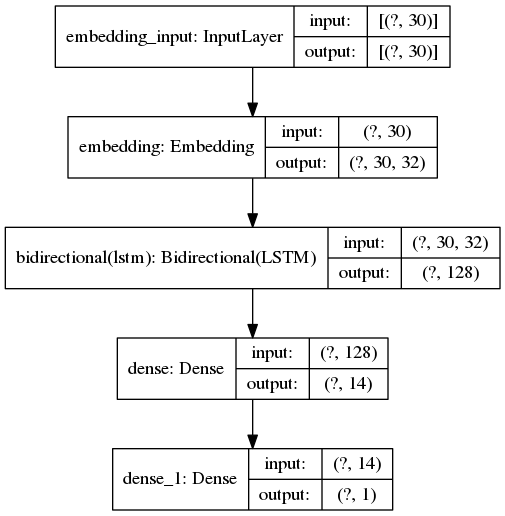

In [46]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [47]:

start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')


Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 8s 1ms/sample - loss: 0.5597 - accuracy: 0.7031 - val_loss: 0.4687 - val_accuracy: 0.7840
Epoch 2/10
6090/6090 [==============================] - 3s 452us/sample - loss: 0.3040 - accuracy: 0.8782 - val_loss: 0.4674 - val_accuracy: 0.7971
Epoch 3/10
6090/6090 [==============================] - 3s 411us/sample - loss: 0.1822 - accuracy: 0.9351 - val_loss: 0.5248 - val_accuracy: 0.7715
Epoch 4/10
6090/6090 [==============================] - 2s 395us/sample - loss: 0.1252 - accuracy: 0.9563 - val_loss: 0.6462 - val_accuracy: 0.7669
Epoch 5/10
6090/6090 [==============================] - 3s 436us/sample - loss: 0.0928 - accuracy: 0.9685 - val_loss: 0.6546 - val_accuracy: 0.7334
Epoch 6/10
6090/6090 [==============================] - 3s 453us/sample - loss: 0.0825 - accuracy: 0.9718 - val_loss: 0.6959 - val_accuracy: 0.7236
Epoch 7/10
6090/6090 [==============================] - 4s 622us/s

In [48]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.559660,0.703120,0.468712,0.783979
1,0.303973,0.878161,0.467429,0.797111
2,0.182154,0.935140,0.524800,0.771504
3,0.125171,0.956322,0.646169,0.766907
4,0.092820,0.968473,0.654568,0.733421


In [49]:
model_loss

,loss,accuracy,val_loss,val_accuracy
0,0.559660,0.703120,0.468712,0.783979
1,0.303973,0.878161,0.467429,0.797111
2,0.182154,0.935140,0.524800,0.771504
3,0.125171,0.956322,0.646169,0.766907
4,0.092820,0.968473,0.654568,0.733421
5,0.082458,0.971757,0.695868,0.723572
6,0.075494,0.972906,0.785385,0.728825
7,0.068246,0.976683,0.767701,0.719632
8,0.062680,0.977340,0.824312,0.722259
9,0.055812,0.977176,0.869954,0.728825


<a id='eval'></a>
# 8. Model Evaluation

In [76]:
predictions = model.predict_classes(testing_padded)   # predict_ clases because is classification problem with the split test

In [51]:
viewPredictions = []
for index,row in testing_sentences.items():
    viewPredictions.append((testing_sentences[index], predictions[index - 6090][0]))
viewPredictions    

[('nowplaying sinking fast never north east unsigned radio listen', 0),
 ('horrible sinking feeling home phone realise g whole time', 0),
 ('nigga car sinking snapping fox priority', 1),
 ('abandonedpics delete one abbandoned sinking darsena castello scaligero di sirmione',
  0),
 ('horrible sinking feeling home phone realise g whole time', 0),
 ('equipment ego break upon dig family internet hoke excepting versus sinking term dfljev',
  0),
 ('currency transgress payday prison ward sinking fund payment unsecured loan jbumzqpk',
  0),
 ('horrible sinking feeling home phone realise g whole time', 0),
 ('lost alone sinking like stone carry onnn', 0),
 ('lying clinton sinking donald trump singing let make america great', 0),
 ('ap slow report sinking boat mediterranean sea shame', 1),
 ('walk plank sinking ship', 0),
 ('sinking ship sinkingshipindy scarlet lane lenore replacing stone saison stonebrewingco',
  0),
 ('horrible sinking feeling home phone realise g whole time', 0),
 ('movie ti

In [52]:
predictions[2][0]

1

In [53]:
from sklearn.metrics import classification_report,confusion_matrix

In [72]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

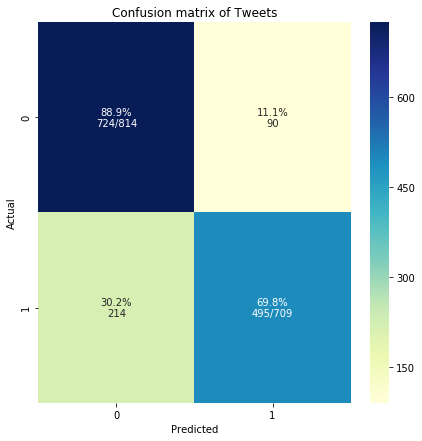

In [77]:
# Showing Confusion Matrix
plot_cm(testing_labels,predictions, 'Confusion matrix of Tweets', figsize=(7,7))

# Using Glove Embeddings

In [56]:
import os
print(os.listdir("../input"))
!ls

['glove-global-vectors-for-word-representation', 'nlp-getting-started']
__notebook_source__.ipynb  model_plot4a.png


In [57]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [58]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in (word_index.items()):
    if i > num_words:
        break
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

In [59]:
model= Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_length,trainable=True)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1281800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,324,105
Trainable params: 1,324,105
Non-trainable params: 0
_________________________________________________________________


In [61]:
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs,batch_size=4, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 58s 10ms/step - loss: 0.6901 - accuracy: 0.5732 - val_loss: 0.6898 - val_accuracy: 0.5345
Epoch 2/10
6090/6090 [==============================] - 58s 9ms/step - loss: 0.6815 - accuracy: 0.5796 - val_loss: 0.6795 - val_accuracy: 0.5384
Epoch 3/10
6090/6090 [==============================] - 58s 10ms/step - loss: 0.6424 - accuracy: 0.6383 - val_loss: 0.5674 - val_accuracy: 0.7656
Epoch 4/10
6090/6090 [==============================] - 58s 10ms/step - loss: 0.5630 - accuracy: 0.7333 - val_loss: 0.5002 - val_accuracy: 0.7754
Epoch 5/10
6090/6090 [==============================] - 57s 9ms/step - loss: 0.5445 - accuracy: 0.7399 - val_loss: 0.4867 - val_accuracy: 0.7794
Epoch 6/10
6090/6090 [==============================] - 58s 9ms/step - loss: 0.5350 - accuracy: 0.7471 - val_loss: 0.4792 - val_accuracy: 0.7873
Epoch 7/10
6090/6090 [==============================] - 58s 10ms/step - loss: 0

# Using the BERT Model

In [78]:
!pip install simpletransformers


     |████████████████████████████████| 215kB 405kB/s eta 0:00:01
     |████████████████████████████████| 51kB 3.7MB/s eta 0:00:011
     |████████████████████████████████| 1.7MB 5.6MB/s eta 0:00:01
     |████████████████████████████████| 1.1MB 13.8MB/s eta 0:00:01
     |████████████████████████████████| 71kB 6.7MB/s  eta 0:00:01
     |████████████████████████████████| 2.9MB 14.6MB/s eta 0:00:01
     |████████████████████████████████| 7.4MB 15.7MB/s eta 0:00:01
     |████████████████████████████████| 122kB 23.9MB/s eta 0:00:01
     |████████████████████████████████| 102kB 9.4MB/s eta 0:00:01
     |████████████████████████████████| 102kB 8.6MB/s eta 0:00:01
     |████████████████████████████████| 890kB 23.5MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 25.0MB/s eta 0:00:01
     |████████████████████████████████| 6.7MB 25.3MB/s eta 0:00:01
     |████████████████████████████████| 112kB 35.1MB/s eta 0:00:01


     |████████████████████████████████| 2.2MB 17.3MB/s eta 0:00:01
     |████████████████████████████████| 122kB 39.5MB/s eta 0:00:01


  Created wheel for seqeval: filename=seqeval-1.2.1-cp36-none-any.whl size=16169 sha256=d5d3f5fc8fc32f6cf8f76590b5c4ded95bf5b73398dd33726adcd4181bf01369
  Stored in directory: /root/.cache/pip/wheels/b4/42/c0/e2d946497f714404c0b78a0ab4c7f45222a293f49320932463
  Created wheel for promise: filename=promise-2.3-cp36-none-any.whl size=21494 sha256=9d55e595479313404be6ff06f97cbe81b7f86a6ebb49482798c7e7b3278be09b
  Stored in directory: /root/.cache/pip/wheels/19/49/34/c3c1e78bcb954c49e5ec0d31784fe63d14d427f316b12fbde9
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=b2a19746fd127c8865832763d011e6e3ebbcd42d84a9f183774dd8f6f7a62b23
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=e5662ce148b5aadb2e07956e8b806fccbb285db181f599cbd1309edfa527b0fe
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


AttributeError: module 'tensorflow_core.keras.activations' has no attribute 'swish'

> # Now working with test dataset

In [74]:

testing_sequences2 = tokenizer.texts_to_sequences(test.text)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [75]:
predictions = model.predict(testing_padded2)

In [64]:
# sample of submission
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [65]:
submission['target'] = (predictions > 0.5).astype(int)

In [66]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,0
3261,10874,1


In [67]:
submission.to_csv("submission.csv", index=False, header=True)

<h2>I hope this notebook <span style="color:red">Useful</span> for you! </h3>

<a href="#top" class="btn btn-primary btn-lg active" role="button" aria-pressed="true">Go to TOP</a>
